In [23]:
import os
import gc
import ast
import numpy as np 
import pandas as pd 

from google.colab import files
from google.colab.patches import cv2_imshow

import matplotlib.pyplot as plt
import cv2
from tqdm.notebook import tqdm

import plotly.express as px
import plotly.graph_objects as go
import plotly
plotly.offline.init_notebook_mode(connected = True)

import tensorflow as tf
from tensorflow.keras.utils import Sequence, to_categorical
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import models

from sklearn.model_selection import train_test_split


In [24]:
! nvidia-smi

Fri Jul 31 15:55:35 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P0    31W /  70W |   4701MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [25]:
from google.colab import drive
drive.mount('/content/drive') # for saving train results

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [29]:
# # Constants and hyperparameters
# MAIN_PATH = '../input/quickdraw-doodle-recognition'
# PREP_DATASET_PATH = '../input/doodle-recognition-prepaired-train-data' 
# TRAIN_SIMPLIFIED_PATH = '../input/quickdraw-doodle-recognition/train_simplified'
SAVING_DIR_PATH = '/content/drive/My Drive/colab_notebooks/Doodle_Classifier/weights'


# Hardcoded constants, don't change them
NCATS = 340
BASE_SIZE = 256 
NCHANNELS = 1

#Fix seeds
SEED = 42
np.random.seed(seed=SEED)
tf.random.set_seed(seed=SEED)

#Hyperparameters
INPUT_SIZE = 64
ALPHA = 1. #Check MobileNetv2 documentation for explanations
EPOCHS = 50
BATCH_SIZE = 64

### Download prepaired dataset from kaggle

In [27]:
# Add kaggle.json key
files.upload()

KeyboardInterrupt: ignored

In [6]:
! mkdir ~/.kaggle #inroot folder 
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [7]:
! kaggle datasets download gooogr/doodle-recognition-prepaired-train-data
! unzip /content/doodle-recognition-prepaired-train-data.zip

 99% 1.56G/1.57G [00:11<00:00, 170MB/s]
100% 1.57G/1.57G [00:11<00:00, 147MB/s]
Archive:  /content/doodle-recognition-prepaired-train-data.zip
  inflating: train_set_30000_340     
  inflating: train_set_5000_340      


In [30]:
%%time
df = pd.read_csv('train_set_5000_340', compression='gzip') #SELECT GZIP FILE HERE

CPU times: user 10.4 s, sys: 653 ms, total: 11.1 s
Wall time: 11.1 s


### Utils

In [31]:
# Utils

def str2list(x):
    return(ast.literal_eval(x))

def draw_cv2(raw_strokes, size=64, lw=4, time_color=False):
    '''
    Took from https://www.kaggle.com/gaborfodor/greyscale-mobilenet-lb-0-892 #6
    '''
    img = np.zeros((BASE_SIZE, BASE_SIZE), np.uint8)
    for t, stroke in enumerate(raw_strokes):
        for i in range(len(stroke[0]) - 1):
            color = 255
            img = cv2.line(img, (stroke[0][i], stroke[1][i]),
                         (stroke[0][i + 1], stroke[1][i + 1]), color, lw)
    if size != BASE_SIZE:
        return cv2.resize(img, (size, size))
    else:
        return img
    
def plot_learnning_curves(history):
    loss = history.history['loss']
    categorical_accuracy = history.history['categorical_accuracy']
    val_loss = history.history['val_loss']
    val_categorical_accuracy = history.history['val_categorical_accuracy']
    
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=list(range(EPOCHS)), y=loss, mode='lines+markers', name='loss'))
    fig.add_trace(go.Scatter(x=list(range(EPOCHS)), y=val_loss, mode='lines+markers', name='val_loss'))
    fig.update_layout(autosize=False,
                      width=900,
                      height=300,
                      margin=dict(l=5, r=5, b=10, t=10, pad=4))
    fig.show()
    
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=list(range(EPOCHS)), y=categorical_accuracy, mode='lines+markers', name = 'accuracy'))
    fig.add_trace(go.Scatter(x=list(range(EPOCHS)), y=val_categorical_accuracy, mode='lines+markers', name = 'val_accuracy'))
    fig.update_layout(autosize=False,
                      width=900,
                      height=300,
                      margin=dict(l=5, r=5, b=10, t=10, pad=4))
    fig.show()

### Data downloading

In [32]:
# Encode categories to numbers
categories_list = sorted(df.word.unique(), key = str.lower)
categories_dict = dict(zip(categories_list, range(len(categories_list))))
df['word_code'] = df['word'].map(categories_dict)

In [33]:
%%time
train_df, valid_df = train_test_split(df, train_size=0.9, stratify=df['word'])

CPU times: user 2.9 s, sys: 31.3 ms, total: 2.93 s
Wall time: 2.93 s


In [34]:
train_df.head()

,drawing,word,key_id,word_code
1071384,"[[[22, 13, 3, 0, 3, 12, 24, 45, 63, 80, 101, 1...",cup,5643988113555456,86
601530,"[[[6, 12, 18, 32, 76, 178, 200, 205, 206, 199,...",crown,5135814222675968,84
1422217,"[[[185, 217, 214, 183], [5, 24, 29, 42]], [[18...",swan,6288401965776896,292
233681,"[[[121, 134, 160, 175, 190, 186, 175, 165, 158...",guitar,6583069488185344,133
919872,"[[[62, 73, 86, 93, 98], [14, 5, 0, 5, 33]], [[...",zebra,4672704244350976,338


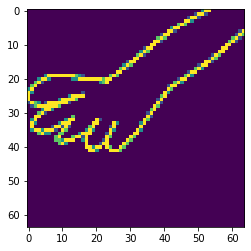

CPU times: user 183 ms, sys: 951 µs, total: 184 ms
Wall time: 185 ms


In [35]:
%%time
# Check image convertation step
img_coords_sample = str2list(df[df['word'] == 'arm']['drawing'].values[0])
img = draw_cv2(img_coords_sample, size = INPUT_SIZE)
plt.imshow(img)
plt.show()

### Keras generator

In [36]:
class DataGenerator(Sequence):
    def __init__(self, list_drawings, labels = None, 
                 batch_size=BATCH_SIZE, dim=(INPUT_SIZE, INPUT_SIZE, NCHANNELS),
                 n_channels=NCHANNELS, n_classes=NCATS, 
                 shuffle=True, is_test=False):
        """
        Initialization
        :param list_drawings: list of all drawings coordinates that use in the generator
        :param labels: list of image labels (file names), our targets
        :param batch_size: batch size at each iteration
        :param dim: tuple indicating image dimension
        :param n_channels: number of image channels
        :param n_classes: number of output masks
        :param shuffle: True to shuffle label indexes after every epoch
        """
        self.list_drawings = list_drawings
        self.indexes = np.arange(len(self.list_drawings))
        self.is_test = is_test
        self.batch_size = batch_size
        self.dim = dim
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

        if not is_test:    
            self.n_classes = n_classes    
            self.labels = labels
            
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        if self.shuffle == True and not self.is_test:
            np.random.shuffle(self.indexes)
            
    def __len__(self):
        """
        Denotes the number of batches per epoch
        """
        l = int(np.floor(len(self.list_drawings) / self.batch_size))+1
        return l
    
    def __getitem__(self, index):
        """
        Generate data batch
        """
        # Generate batch indexes
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        # Get image IDs
        temp_draw_list = [self.list_drawings[i] for i in indexes]
        temp_label_list = [self.labels[i] for i in indexes]
        if not self.is_test:
            X, y = self.__generate_train_data(temp_draw_list, temp_label_list)
            return X, y
        else:
            X = self.__generate_test_data(temp_draw_list)
            return X
    
    def __generate_train_data(self, temp_draw_list, temp_label_list):
        # Initialization
        X = np.empty((len(temp_draw_list), *self.dim))
        y = np.empty((len(temp_draw_list)), dtype=np.int16)
        # Fill data
        for i, draw in enumerate(temp_draw_list):
            img = draw_cv2(str2list(draw), size = self.dim[0])            
            X[i, ] = np.expand_dims(img, axis = -1)
            y[i, ] = temp_label_list[i]
        return X, to_categorical(y, num_classes=self.n_classes)
    
    def __generate_test_data(self, temp_draw_list):
        # Initialization
        X = np.empty((len(temp_draw_list), *self.dim))
        # Fill data
        for i, draw in enumerate(temp_draw_list):
            img = draw_cv2(str2list(draw), size = self.dim[0])            
            X[i, ] = np.expand_dims(img, axis = -1)
        return X
        
    
        

In [37]:
train_gen = DataGenerator(list_drawings=train_df.drawing.values, 
                          labels=train_df.word_code.values, 
                          batch_size=BATCH_SIZE)
valid_gen = DataGenerator(list_drawings=valid_df.drawing.values, 
                          labels=valid_df.word_code.values, 
                          batch_size=BATCH_SIZE)
# test_gen = DataGenerator(list_drawings=test_df.drawing.values, 
#                           is_test=True, 
#                           batch_size=1)

X shape: (64, 64, 64, 1), y shape: (64, 340)


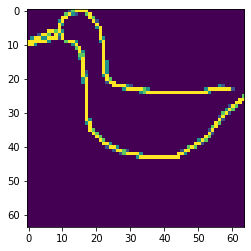

CPU times: user 129 ms, sys: 5.99 ms, total: 135 ms
Wall time: 133 ms


In [38]:
%%time
# Check generator
X, y = train_gen.__getitem__(index=1)
print('X shape: {}, y shape: {}'.format(X.shape, y.shape))
plt.imshow(X[0, :, :, 0])
plt.show()

### Keras MobileNetv2<br>
MobileNetv2 docs: https://keras.io/api/applications/mobilenet/

In [45]:
model_callbacks = [EarlyStopping(monitor='val_loss', 
                                 patience=6, 
                                 restore_best_weights = True),
                   
                   ModelCheckpoint(filepath=os.path.join(SAVING_DIR_PATH, 
                                                         'MobileNetV2_ft.epoch={epoch:02d}-val_loss={val_loss:.2f}.h5'),
                                   save_weights_only=False,
                                   monitor='val_loss', 
                                   save_best_only=True),
                  
                    CSVLogger(os.path.join(SAVING_DIR_PATH, 'log.csv'), append=True, separator=';'),
                  
                    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_delta=0.001,
                          mode='min', min_lr=1e-6, verbose=1)]

In [46]:
# ADD Data augmentation

# ADD Tranfer learning and freeze first layers

In [47]:
def get_model(path_to_model=None):
    if path_to_model  is None:
        model = MobileNetV2(input_shape=(INPUT_SIZE, INPUT_SIZE, NCHANNELS), 
                    alpha=ALPHA, 
                    weights=None, 
                    classes=NCATS)
    else:
        model = models.load_model(path_to_model)
    return model

In [48]:
model = get_model()
model.compile(optimizer=Adam(lr=0.01),  #0.01 for 1 stage, 0.0001 for finetuning
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])
print(model.summary())

Model: "mobilenetv2_1.00_64"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 65, 65, 1)    0           input_2[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 32, 32, 32)   288         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 32, 32, 32)   128         Conv1[0][0]                      
________________________________________________________________________________

In [ ]:
history = model.fit_generator(generator=train_gen, 
                              validation_data=valid_gen, 
                              epochs=EPOCHS, 
                              verbose=1,
                              steps_per_epoch=len(train_df) // BATCH_SIZE,
                              validation_steps=1000,
                              callbacks=model_callbacks)

Epoch 1/50
23906/23906 [==============================] - 822s 34ms/step - loss: 2.4271 - categorical_accuracy: 0.4397 - val_loss: 3.3186 - val_categorical_accuracy: 0.3543 - lr: 0.0100
Epoch 2/50
23906/23906 [==============================] - 817s 34ms/step - loss: 1.6979 - categorical_accuracy: 0.5879 - val_loss: 1.9442 - val_categorical_accuracy: 0.5446 - lr: 0.0100
Epoch 3/50
23906/23906 [==============================] - 811s 34ms/step - loss: 1.5515 - categorical_accuracy: 0.6202 - val_loss: 1.6667 - val_categorical_accuracy: 0.5965 - lr: 0.0100
Epoch 4/50
23906/23906 [==============================] - 821s 34ms/step - loss: 1.4706 - categorical_accuracy: 0.6387 - val_loss: 1.5872 - val_categorical_accuracy: 0.6140 - lr: 0.0100
Epoch 5/50
23906/23906 [==============================] - 820s 34ms/step - loss: 1.4163 - categorical_accuracy: 0.6509 - val_loss: 1.6968 - val_categorical_accuracy: 0.5825 - lr: 0.0100
Epoch 6/50
 3492/23906 [===>..........................] - ETA: 11:23 -

In [ ]:
plot_learnning_curves(history)